In [2]:
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow .keras.applications import resnet50
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
import recmetrics
from typing import List

# Getting the Data

In [3]:
# Create a list of all the images in our dataset
dataset_path = '../tiny_imagenet/train'
image_path = '{dataset_path}/{label}/{name}'
image_path_list = []

for label_name in os.listdir(dataset_path):
    for filename in os.listdir(os.path.join(dataset_path, label_name)):
        if filename == '.DS_Store':
            pass
        image_path_list.append(image_path.format(dataset_path=dataset_path, label=label_name, name=filename))


In [5]:
# Creating labels and image list
labels = {}
for label_name in os.listdir(dataset_path):
    labels[label_name] = (os.listdir(os.path.join(dataset_path, label_name)))

print(labels)

{'n03394916': ['ILSVRC2012_val_00046669.JPEG', 'n03394916_58454.JPEG', 'n03394916_32588.JPEG', 'n03394916_33663.JPEG', 'n03394916_27948.JPEG', 'n03394916_38644.JPEG', 'n03394916_35076.JPEG', 'n03394916_38214.JPEG', 'n03394916_23008.JPEG', 'n03394916_33008.JPEG', 'n03394916_7606.JPEG', 'n03394916_35133.JPEG', 'n03394916_28428.JPEG', 'n03394916_53473.JPEG', 'n03394916_28994.JPEG', 'n03394916_44089.JPEG', 'n03394916_11495.JPEG', 'n03394916_29106.JPEG', 'n03394916_20777.JPEG', 'n03394916_34364.JPEG', 'n03394916_71778.JPEG', 'n03394916_28717.JPEG', 'n03394916_38828.JPEG', 'n03394916_38605.JPEG', 'n03394916_34299.JPEG', 'n03394916_34333.JPEG', 'n03394916_60997.JPEG', 'n03394916_36924.JPEG', 'n03394916_42673.JPEG', 'n03394916_1906.JPEG', 'n03394916_33527.JPEG', 'n03394916_29983.JPEG', 'n03394916_33177.JPEG', 'n03394916_35109.JPEG', 'n03394916_69558.JPEG', 'n03394916_40265.JPEG', 'n03394916_28107.JPEG', 'n03394916_30188.JPEG', 'n03394916_54699.JPEG', 'n03394916_27026.JPEG', 'n03394916_52126.JP

In [6]:
print(list(labels.keys()))

['n03394916', 'n03417042', 'n03445777', 'n02102040', 'n03425413', 'n03888257', 'n03028079', 'n03000684', 'n01440764', 'n02979186']


# Create feauture representation for the data

In [40]:
# Example
random_image_path = '../tiny_imagenet/train/n02979186/n02979186_5497.JPEG'
toy_image = load_img(random_image_path, target_size=(256, 256))
toy_image = img_to_array(toy_image)
toy_image = np.expand_dims(toy_image, axis=0)
preprocess_toy_image = resnet50.preprocess_input(toy_image)
toy_image.shape

(1, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


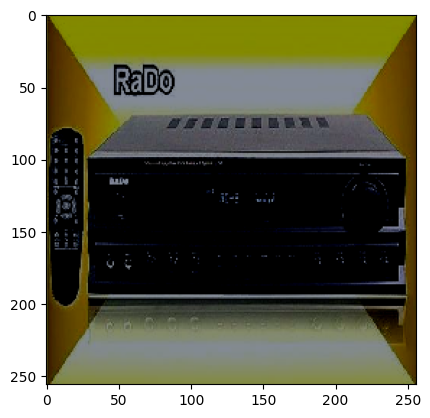

In [41]:
plt.imshow(toy_image[0,...]/255)

In [8]:
model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=None,
    pooling='max'
)

In [12]:
image_feature = []
image_labels = []
for image_path in tqdm(image_path_list):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    preprocess_image = resnet50.preprocess_input(image)
    feature = model.predict(preprocess_image, verbose=0).flatten()
    image_label = image_path.split('/')[-2]
    image_feature.append(feature)
    image_labels.append(image_label)

100%|██████████| 9469/9469 [11:45<00:00, 13.42it/s]


# Using KNN Classifier

In [18]:
X = np.array(image_feature)
y = np.array(image_labels)

In [19]:
print(X.shape)
print(y.shape)

(9469, 2048)
(9469,)


In [38]:
from sklearn.neighbors import KNeighborsClassifier

In [39]:
knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
knn = knn.fit(X, y)

In [60]:
train_dir = '../tiny_imagenet/train/'

tf_image_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels=None,
    label_mode=None,
    batch_size=32,
)


Found 9469 files belonging to 1 classes.


In [51]:
tf_image_feature = []
for tf_image in tqdm(tf_image_dataset):
    preprocess_tf_image = resnet50.preprocess_input(tf_image)
    feature = model.predict(preprocess_tf_image, verbose=0, use_multiprocessing=True)
    for i in range(feature.shape[0]):
        tf_image_feature.append(feature[i,...])


100%|██████████| 296/296 [04:58<00:00,  1.01s/it]


In [24]:
test_path = '../tiny_imagenet/val'
tf_image_test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=test_path,
    class_names=['n03394916', 'n03417042', 'n03445777', 'n02102040', 'n03425413', 'n03888257', 'n03028079', 'n03000684', 'n01440764', 'n02979186'],
    label_mode='int',
    labels='inferred',
    shuffle=False,
    batch_size=32,
)

Found 3925 files belonging to 10 classes.


In [26]:
for image, name in tf_image_test_dataset:
    print(image.shape)
    print(name.shape)
    print(name[1,...])

(32, 256, 256, 3)
(32,)
tf.Tensor(8, shape=(), dtype=int32)
(32, 256, 256, 3)
(32,)
tf.Tensor(8, shape=(), dtype=int32)
(32, 256, 256, 3)
(32,)
tf.Tensor(8, shape=(), dtype=int32)
(32, 256, 256, 3)
(32,)
tf.Tensor(8, shape=(), dtype=int32)
(32, 256, 256, 3)
(32,)
tf.Tensor(8, shape=(), dtype=int32)
(32, 256, 256, 3)
(32,)
tf.Tensor(8, shape=(), dtype=int32)
(32, 256, 256, 3)
(32,)
tf.Tensor(8, shape=(), dtype=int32)
(32, 256, 256, 3)
(32,)
tf.Tensor(8, shape=(), dtype=int32)
(32, 256, 256, 3)
(32,)
tf.Tensor(8, shape=(), dtype=int32)
(32, 256, 256, 3)
(32,)
tf.Tensor(8, shape=(), dtype=int32)
(32, 256, 256, 3)
(32,)
tf.Tensor(8, shape=(), dtype=int32)
(32, 256, 256, 3)
(32,)
tf.Tensor(8, shape=(), dtype=int32)
(32, 256, 256, 3)
(32,)
tf.Tensor(8, shape=(), dtype=int32)
(32, 256, 256, 3)
(32,)
tf.Tensor(3, shape=(), dtype=int32)
(32, 256, 256, 3)
(32,)
tf.Tensor(3, shape=(), dtype=int32)
(32, 256, 256, 3)
(32,)
tf.Tensor(3, shape=(), dtype=int32)
(32, 256, 256, 3)
(32,)
tf.Tensor(3, sha

In [ ]:
tf_image_feature = []
for tf_image in tqdm(tf_image_dataset):
    preprocess_tf_image = resnet50.preprocess_input(tf_image)
    feature = model.predict(preprocess_tf_image, verbose=0, use_multiprocessing=True)
    for i in range(feature.shape[0]):
        tf_image_feature.append(feature[i,...])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
random_testing_image_path = '../tiny_imagenet/val/n03417042/ILSVRC2012_val_00033842.JPEG'
# getting the feauture for the testing image
test_image = load_img(random_testing_image_path, target_size=(224, 224))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
preprocess_test_image = resnet50.preprocess_input(test_image)
feature = model.predict(preprocess_test_image).flatten()





1/1 [==============================] - 0s 74ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


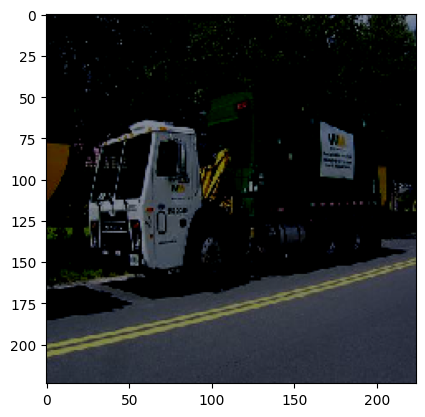

In [ ]:
plt.imshow(test_image[0,...]/255)

In [ ]:
feature.shape

(2048,)

In [ ]:
similarity = []
for feauture_y, _ in tqdm(image_feature):
    similarity.append(cosine_similarity(feature.reshape(1, -1), feauture_y.reshape(1, -1))[0][0])
index_pos = sorted(list(enumerate(similarity)), reverse=True, key=lambda x: x[1])[0:20]
index_position = [x[0] for x in index_pos]


100%|██████████| 9469/9469 [00:01<00:00, 7990.22it/s]


In [ ]:
print(index_position)

[1790, 1554, 1193, 998, 1601, 1133, 1822, 1546, 1106, 1641, 1834, 1660, 1236, 1104, 1563, 964, 1073, 1631, 1531, 1615]


In [ ]:
similar_image_path = image_path_list[index_position[4]]
similar_image = load_img(similar_image_path, target_size=(256, 256))
similar_image = img_to_array(similar_image)

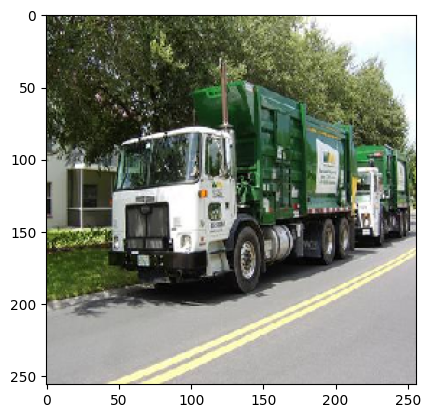

In [ ]:
plt.imshow(similar_image/255)

# Evaluation your model

In [28]:
test_path = '../tiny_imagenet/val'
image_path = '{dataset_path}/{label}/{name}'
test_path_list = []
for label_name in os.listdir(test_path):
    for filename in os.listdir(os.path.join(test_path, label_name)):
        if filename == '.DS_Store':
            pass
        test_path_list.append(image_path.format(dataset_path=test_path, label=label_name, name=filename))
        

In [ ]:
## Creating features for the test data
test_feature = []
pre_processed = []
for image_path in tqdm(test_path_list):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    preprocdess_image = resnet50.preprocess_input(image)
    pre_processed.append(preprocess_image, image_path.split('/')[-2])

feature = model.predict(preprocess_image, verbose=0).flatten()
test_feature.append((feature, image_path.split('/')[-2])) # image_path.split('/')[-2] is to get the label of the image

100%|██████████| 3925/3925 [04:46<00:00, 13.71it/s]


In [ ]:
k = 20
predictions = []
test_labels = []
for feature_x, label in tqdm(test_feature):
    similarity = []
    for feauture_y, _ in image_feature:
        similarity.append(cosine_similarity(feature_x.reshape(1, -1), feauture_y.reshape(1, -1))[0][0])
    index_pos = sorted(list(enumerate(similarity)), reverse=True, key=lambda x: x[1])[0:20]
    index_list = [x[0] for x in index_pos]

    prediction_name = [image_path_list[i].split('/')[-1] for i in  index_list]
    predictions.append(prediction_name)
    test_labels.append(labels[label])

  9%|▉         | 345/3925 [08:05<1:23:59,  1.41s/it] 


KeyboardInterrupt: 

In [ ]:
mapk(actual=test_labels, predicted=predictions, k=100)

0.9850602679254284

In [ ]:
recmetrics.mark(actual=test_labels, predicted=predictions, k=60)

0.020239997970420236

In [7]:
def _precision(predicted, actual):
    prec = [value for value in predicted if value in actual]
    prec = float(len(prec)) / float(len(predicted))
    return prec

def _apk(actual: list, predicted: list, k=10) -> float:
    """
    Computes the average precision at k.
    Parameters
    ----------
    actual : list
        A list of actual items to be predicted
    predicted : list
        An ordered list of predicted items
    k : int, default = 10
        Number of predictions to consider
    Returns:
    -------
    score : float
        The average precision at k.
    """
    if not predicted or not actual:
        return 0.0
    
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    true_positives = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            max_ix = min(i + 1, len(predicted))
            score += _precision(predicted[:max_ix], actual)
            true_positives += 1
    
    if score == 0.0:
        return 0.0
    
    return score / true_positives

def mapk(actual: List[list], predicted: List[list], k: int=10) -> float:
    """
    Computes the mean average precision at k.
    Parameters
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        mark: float
            The mean average precision at k (map@k)
    """
    if len(actual) != len(predicted):
        raise AssertionError("Length mismatched")
    
    return np.mean([_apk(a,p,k) for a,p in zip(actual, predicted)])



# Using KNN

In [64]:
# Create a list of all the images in our dataset
dataset_path = '../tiny_imagenet/train'
image_path = '{dataset_path}/{label}/{name}'
image_path_list = []

for label_name in os.listdir(dataset_path):
    for filename in os.listdir(os.path.join(dataset_path, label_name)):
        if filename == '.DS_Store':
            pass
        image_path_list.append(image_path.format(dataset_path=dataset_path, label=label_name, name=filename))

In [65]:
# Creating labels and image list
labels = {}
for label_name in os.listdir(dataset_path):
    labels[label_name] = (os.listdir(os.path.join(dataset_path, label_name)))

print(labels)

{'n03394916': ['ILSVRC2012_val_00046669.JPEG', 'n03394916_58454.JPEG', 'n03394916_32588.JPEG', 'n03394916_33663.JPEG', 'n03394916_27948.JPEG', 'n03394916_38644.JPEG', 'n03394916_35076.JPEG', 'n03394916_38214.JPEG', 'n03394916_23008.JPEG', 'n03394916_33008.JPEG', 'n03394916_7606.JPEG', 'n03394916_35133.JPEG', 'n03394916_28428.JPEG', 'n03394916_53473.JPEG', 'n03394916_28994.JPEG', 'n03394916_44089.JPEG', 'n03394916_11495.JPEG', 'n03394916_29106.JPEG', 'n03394916_20777.JPEG', 'n03394916_34364.JPEG', 'n03394916_71778.JPEG', 'n03394916_28717.JPEG', 'n03394916_38828.JPEG', 'n03394916_38605.JPEG', 'n03394916_34299.JPEG', 'n03394916_34333.JPEG', 'n03394916_60997.JPEG', 'n03394916_36924.JPEG', 'n03394916_42673.JPEG', 'n03394916_1906.JPEG', 'n03394916_33527.JPEG', 'n03394916_29983.JPEG', 'n03394916_33177.JPEG', 'n03394916_35109.JPEG', 'n03394916_69558.JPEG', 'n03394916_40265.JPEG', 'n03394916_28107.JPEG', 'n03394916_30188.JPEG', 'n03394916_54699.JPEG', 'n03394916_27026.JPEG', 'n03394916_52126.JP

In [66]:
model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=None,
    pooling='max'
)

In [67]:
image_feature = []
for image_path in tqdm(image_path_list):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    preprocess_image = resnet50.preprocess_input(image)
    feature = model.predict(preprocess_image, verbose=0).flatten()
    image_name = image_path.split('/')[-1] 
    image_feature.append(feature)

100%|██████████| 9469/9469 [10:43<00:00, 14.72it/s]


In [33]:
from sklearn.neighbors import NearestNeighbors

In [34]:
knn = NearestNeighbors(n_jobs=-1, n_neighbors=10)
knn.fit(image_feature)

NearestNeighbors(n_jobs=-1, n_neighbors=10)

In [40]:
random_testing_image_path = '../tiny_imagenet/val/n03417042/ILSVRC2012_val_00033842.JPEG'
# getting the feauture for the testing image
test_image = load_img(random_testing_image_path, target_size=(224, 224))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
preprocess_test_image = resnet50.preprocess_input(test_image)
feature = model.predict(preprocess_test_image).flatten()

1/1 [==============================] - 0s 101ms/step


In [41]:
index_list = knn.kneighbors(feature.reshape(1, -1), n_neighbors=4, return_distance=False)[0]

[1790 1193 1554  998]


In [25]:
test_path = '../tiny_imagenet/val'
image_path = '{dataset_path}/{label}/{name}'
test_path_list = []
for label_name in os.listdir(test_path):
    for filename in os.listdir(os.path.join(test_path, label_name)):
        if filename == '.DS_Store':
            pass
        test_path_list.append(image_path.format(dataset_path=test_path, label=label_name, name=filename))

In [26]:
## Creating features for the test data
test_feature = []
for image_path in tqdm(test_path_list):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    preprocess_image = resnet50.preprocess_input(image)
    feature = model.predict(preprocess_image, verbose=0).flatten()
    test_feature.append((feature, image_path.split('/')[-2])) # image_path.split('/')[-2] is to get the label of the image

100%|██████████| 3925/3925 [04:44<00:00, 13.79it/s]


In [36]:
k = 20
predictions = []
test_labels = []
for feature_x, label in tqdm(test_feature):
    index_list = knn.kneighbors(feature_x.reshape(1, -1), n_neighbors=20, return_distance=False)[0]
    prediction_name = [image_path_list[i].split('/')[-1] for i in  index_list]
    predictions.append(prediction_name)
    test_labels.append(labels[label])

  0%|          | 0/3925 [00:00<?, ?it/s]

100%|██████████| 3925/3925 [01:18<00:00, 50.30it/s]


In [37]:
mapk(actual=test_labels, predicted=predictions, k=20)

0.967558047646581

In [32]:
recmetrics.mark(actual=test_labels, predicted=predictions, k=60)

0.01980246048157655

# Testing unsupervised KNN vs KNNClassifier

In [3]:
# Create a list of all the images in our dataset
dataset_path = '../tiny_imagenet/train'
image_path = '{dataset_path}/{label}/{name}'
image_path_list = []

for label_name in os.listdir(dataset_path):
    for filename in os.listdir(os.path.join(dataset_path, label_name)):
        if filename == '.DS_Store':
            pass
        image_path_list.append(image_path.format(dataset_path=dataset_path, label=label_name, name=filename))

In [4]:
# Creating labels and image list
labels = {}
for label_name in os.listdir(dataset_path):
    labels[label_name] = (os.listdir(os.path.join(dataset_path, label_name)))

print(labels)

{'n03394916': ['ILSVRC2012_val_00046669.JPEG', 'n03394916_58454.JPEG', 'n03394916_32588.JPEG', 'n03394916_33663.JPEG', 'n03394916_27948.JPEG', 'n03394916_38644.JPEG', 'n03394916_35076.JPEG', 'n03394916_38214.JPEG', 'n03394916_23008.JPEG', 'n03394916_33008.JPEG', 'n03394916_7606.JPEG', 'n03394916_35133.JPEG', 'n03394916_28428.JPEG', 'n03394916_53473.JPEG', 'n03394916_28994.JPEG', 'n03394916_44089.JPEG', 'n03394916_11495.JPEG', 'n03394916_29106.JPEG', 'n03394916_20777.JPEG', 'n03394916_34364.JPEG', 'n03394916_71778.JPEG', 'n03394916_28717.JPEG', 'n03394916_38828.JPEG', 'n03394916_38605.JPEG', 'n03394916_34299.JPEG', 'n03394916_34333.JPEG', 'n03394916_60997.JPEG', 'n03394916_36924.JPEG', 'n03394916_42673.JPEG', 'n03394916_1906.JPEG', 'n03394916_33527.JPEG', 'n03394916_29983.JPEG', 'n03394916_33177.JPEG', 'n03394916_35109.JPEG', 'n03394916_69558.JPEG', 'n03394916_40265.JPEG', 'n03394916_28107.JPEG', 'n03394916_30188.JPEG', 'n03394916_54699.JPEG', 'n03394916_27026.JPEG', 'n03394916_52126.JP

In [5]:
model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=None,
    pooling='max'
)

In [6]:
image_feature = []
image_labels = []
for image_path in tqdm(image_path_list):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    preprocess_image = resnet50.preprocess_input(image)
    feature = model.predict(preprocess_image, verbose=0).flatten()
    image_label = image_path.split('/')[-2]
    image_feature.append(feature)
    image_labels.append(image_label)

100%|██████████| 9469/9469 [12:57<00:00, 12.17it/s]


In [8]:
X = np.array(image_feature)
y = np.array(image_labels)

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [10]:
knn_classifier = KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
knn_classifier = knn_classifier.fit(X, y)

In [11]:
test_path = '../tiny_imagenet/val'
image_path = '{dataset_path}/{label}/{name}'
test_path_list = []
for label_name in os.listdir(test_path):
    for filename in os.listdir(os.path.join(test_path, label_name)):
        if filename == '.DS_Store':
            pass
        test_path_list.append(image_path.format(dataset_path=test_path, label=label_name, name=filename))

In [12]:
## Creating features for the test data
test_feature = []
for image_path in tqdm(test_path_list):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    preprocess_image = resnet50.preprocess_input(image)
    feature = model.predict(preprocess_image, verbose=0).flatten()
    test_feature.append((feature, image_path.split('/')[-2])) # image_path.split('/')[-2] is to get the label of the image

100%|██████████| 3925/3925 [05:00<00:00, 13.07it/s]


In [13]:
k = 20
predictions = []
test_labels = []
for feature_x, label in tqdm(test_feature):
    index_list = knn_classifier.kneighbors(feature_x.reshape(1, -1), n_neighbors=20, return_distance=False)[0]
    prediction_name = [image_path_list[i].split('/')[-1] for i in  index_list]
    predictions.append(prediction_name)
    test_labels.append(labels[label])

100%|██████████| 3925/3925 [01:31<00:00, 43.08it/s]


In [14]:
mapk(actual=test_labels, predicted=predictions, k=20)

0.967558047646581

In [16]:
from sklearn.neighbors import NearestNeighbors

In [17]:
knn = NearestNeighbors(n_jobs=-1, n_neighbors=10)
knn.fit(X)

NearestNeighbors(n_jobs=-1, n_neighbors=10)

In [18]:
k = 20
predictions = []
test_labels = []
for feature_x, label in tqdm(test_feature):
    index_list = knn.kneighbors(feature_x.reshape(1, -1), n_neighbors=20, return_distance=False)[0]
    prediction_name = [image_path_list[i].split('/')[-1] for i in  index_list]
    predictions.append(prediction_name)
    test_labels.append(labels[label])

100%|██████████| 3925/3925 [01:09<00:00, 56.55it/s]


In [19]:
mapk(actual=test_labels, predicted=predictions, k=20)

0.967558047646581

In [20]:
random_testing_image_path = '../tiny_imagenet/val/n03417042/ILSVRC2012_val_00033842.JPEG'
# getting the feauture for the testing image
test_image = load_img(random_testing_image_path, target_size=(224, 224))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
preprocess_test_image = resnet50.preprocess_input(test_image)
test_feature = model.predict(preprocess_test_image).flatten()

1/1 [==============================] - 0s 97ms/step


In [24]:
index_list = knn.kneighbors(test_feature.reshape(1, -1), n_neighbors=20, return_distance=False)[0]

[1790 1193 1554  998 1822 1133 1601 1106 1641 1615 1706 1236 1104  972
 1660 1546 1563 1387 1631 1073]


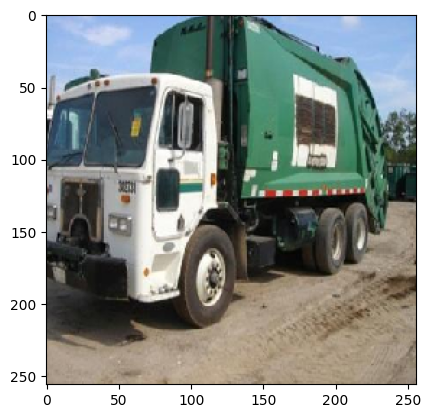

In [35]:
random_pos = 10
similar_image_path = image_path_list[index_list[random_pos]]
similar_image = load_img(similar_image_path, target_size=(256, 256))
similar_image = img_to_array(similar_image)
plt.imshow(similar_image/255)
print(index_list)

[1790 1193 1554  998 1822 1133 1601 1106 1641 1615 1706 1236 1104  972
 1660 1546 1563 1387 1631 1073]
[1790 1193 1554  998 1822 1133 1601 1106 1641 1615 1706 1236 1104  972
 1660 1546 1563 1387 1631 1073]


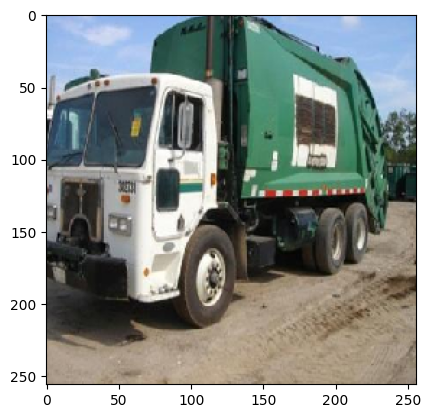

In [36]:
index_list_classifier = knn_classifier.kneighbors(test_feature.reshape(1, -1), n_neighbors=20, return_distance=False)[0]
print(index_list_classifier)
random_pos = 10
similar_image_path = image_path_list[index_list[random_pos]]
similar_image = load_img(similar_image_path, target_size=(256, 256))
similar_image = img_to_array(similar_image)
plt.imshow(similar_image/255)
print(index_list)